## Relevant data is key. Right data types. Necessary columns. No missing data. And any other structural preferences

### before we do any analysis we have to load and prepare our dataset(s). In this case our desired dataset requires combining variables from more than 2 datasets

In [1]:
#importing data manipulation library
import pandas as pd
import numpy as np

In [2]:
#loading our data
data = 'raw_data/his_master_list_with_coordinates.xlsx'

site_data = pd.read_excel(data)

#sample 2 records for our new dataframe
site_data.sample(2)

,mfl_code,FacilityName,County,SubCounty,Owner,lat,lon,SDP,CT,HTS,...,IL_lab_manifest,IL_3_PM,IL_AIR,IL_nimeconfirm,MHealth_Nishauri,MHealth_C4C,MHealth_Ushauri,MHealth_Mlab,MHealth_ART_Directory,MHealth_Psurvey
1006,14031,Randung' Dispensary,Homa Bay,Rangwe,Ministry of Health,-0.63551,34.56268,LVCT Vukisha 95,YES,YES,...,NaN,NaN,NO,NaN,NaN,NaN,YES,NO,NaN,NaN
1996,28592,LVCT Health (Ng'ando Dreams Site),Nairobi,Dagoretti South,Non Governmental organisation,NaN,NaN,CIHEB CONNECT,NO,YES,...,NaN,NaN,NO,NaN,NO,NaN,YES,NO,NaN,NaN


In [3]:
#check for duplicate data
site_data[site_data.duplicated()]

,mfl_code,FacilityName,County,SubCounty,Owner,lat,lon,SDP,CT,HTS,...,IL_lab_manifest,IL_3_PM,IL_AIR,IL_nimeconfirm,MHealth_Nishauri,MHealth_C4C,MHealth_Ushauri,MHealth_Mlab,MHealth_ART_Directory,MHealth_Psurvey


In [4]:
#quick look at the columns to see the relevant ones
site_data.columns

Index(['mfl_code', 'FacilityName', 'County', 'SubCounty', 'Owner', 'lat',
       'lon', 'SDP', 'CT', 'HTS', 'IL', 'MHealth', 'KP', 'EMR', 'EMRStatus',
       'DateOfEmrImplementation', 'ModeOfEMRUse', 'Lab_Manifest', 'MNCH', 'TB',
       'OVC', 'OTZ', 'PREP', 'KP.1', 'HIV', 'TPT', 'Covid_19', 'EVMMC',
       'HTS_Status', 'HTS_Use', 'HTS_Deployment', 'IL_Status', 'IL_WebADT',
       'IL_Mlab', 'IL_Ushauri', 'IL_lab_manifest', 'IL_3_PM', 'IL_AIR',
       'IL_nimeconfirm', 'MHealth_Nishauri', 'MHealth_C4C', 'MHealth_Ushauri',
       'MHealth_Mlab', 'MHealth_ART_Directory', 'MHealth_Psurvey'],
      dtype='object')

In [5]:
#removing the columns we do not need from the dataframe
site_data = site_data.drop(['CT', 'HTS', 'IL', 'MHealth', 'KP', 'EMR', 'EMRStatus',
       'DateOfEmrImplementation', 'ModeOfEMRUse', 'Lab_Manifest', 'MNCH', 'TB',
       'OVC', 'OTZ', 'PREP', 'KP.1', 'HIV', 'TPT', 'Covid_19', 'EVMMC',
       'HTS_Status', 'HTS_Use', 'HTS_Deployment', 'IL_Status', 'IL_WebADT',
       'IL_Mlab', 'IL_Ushauri', 'IL_lab_manifest', 'IL_3_PM', 'IL_AIR',
       'IL_nimeconfirm', 'MHealth_Nishauri', 'MHealth_C4C', 'MHealth_Ushauri',
       'MHealth_Mlab', 'MHealth_ART_Directory', 'MHealth_Psurvey'], axis=1)

In [6]:
#since we are only interested in a specific implementing partner
site_data['SDP'].unique()

array(['LVCT Dhibiti', 'USAID Jamii Tekelezi', 'Nyeri CHMT',
       'USAID Tujenge Jamii', 'KCCB ACTS', 'LVCT Prisons',
       'CHAK CHAP STAWISHA', 'USAID Stawisha Pwani',
       'Bomu Hospital Affiliated Sites', 'HJF-Nairobi', 'CIHEB Imara',
       'DREAMS Trust Kenya', 'USAID Fahari ya Jamii', 'CIHEB CONNECT',
       'Coptic Hospitals', 'Aids Healthcare Foundation Kenya', 'COGRI',
       'CHS Shinda Tena', 'LVCT Vukisha 95', 'CIHEB Entrench',
       'Homa Bay CHMT', 'USAID NURU YA MTOTO', 'HJF-Kisumu West',
       'Siaya CHMT', 'Migori CHMT', 'USAID Boresha Jamii',
       'HJF-South Rift Valley', 'USAID AMPATH Uzima',
       'USAID Imarisha Jamii', nan, 'USAID Dumisha Afya', 'No Partner',
       'Hope Worldwide Kenya'], dtype=object)

In [7]:
#the implementing sdp to filter
partner_filter = 'KCCB ACTS'

#@allows us to pass our string variable through the query method. we also use method chaining to do addition manipulations on the resulting data.
kccb_sites = site_data.query('SDP == @partner_filter').reset_index().drop(['index'], axis=1)
kccb_sites.head(4)

,mfl_code,FacilityName,County,SubCounty,Owner,lat,lon,SDP
0,13473,Aluor Mission Health Centre,Siaya,Gem,Kenya Episcopal Conference-Catholic Secretariat,0.01047,34.46500,KCCB ACTS
1,13488,Asumbi Mission Hospital,Homa Bay,Rangwe,Kenya Episcopal Conference-Catholic Secretariat,-0.62079,34.61453,KCCB ACTS
2,13491,Awasi Mission Health Center,Kisumu,Nyando,Kenya Episcopal Conference-Catholic Secretariat,-0.16043,35.07395,KCCB ACTS
3,12875,Babadogo (EDARP),Nairobi,Ruaraka,Kenya Episcopal Conference-Catholic Secretariat,-1.23916,36.88640,KCCB ACTS


In [8]:
#checking for any missing values
kccb_sites.isna().value_counts()

mfl_code  FacilityName  County  SubCounty  Owner  lat    lon    SDP  
False     False         False   False      False  False  False  False    105
Name: count, dtype: int64

In [9]:
#saving our dataframe in a file for future use
kccb_sites.to_excel('processed_data/cleaned_kccb_his_master_coordinates.xlsx', index=False)

no data is missing and we can also see we have 105 records equating to __105 facility under kccb-acts sdp__

### our first dataset is cleaned and now we can do some few EDA on it

In [10]:
#we can also use the value_counts() method to see the owners of the 105 sites
kccb_sites.Owner.value_counts()

Owner
Kenya Episcopal Conference-Catholic Secretariat    64
Other Faith Based                                  17
Christian Health Association of Kenya              16
Ministry of Health                                  3
Non-Governmental Organizations                      1
Private Practice - Unspecified                      1
Private Enterprise (Institution)                    1
Kenya MPDB - Institution                            1
Nursing Council of Kenya                            1
Name: count, dtype: int64

64 sites belong to *__Kenya Episcopal Conference-Catholic Secretariat__*

### some quick visualization test

In [11]:
import matplotlib.pyplot as plt

In [12]:
print(f'KCCB ACTS supports facilities in {kccb_sites.County.nunique()} counties')

KCCB ACTS supports facilities in 20 counties


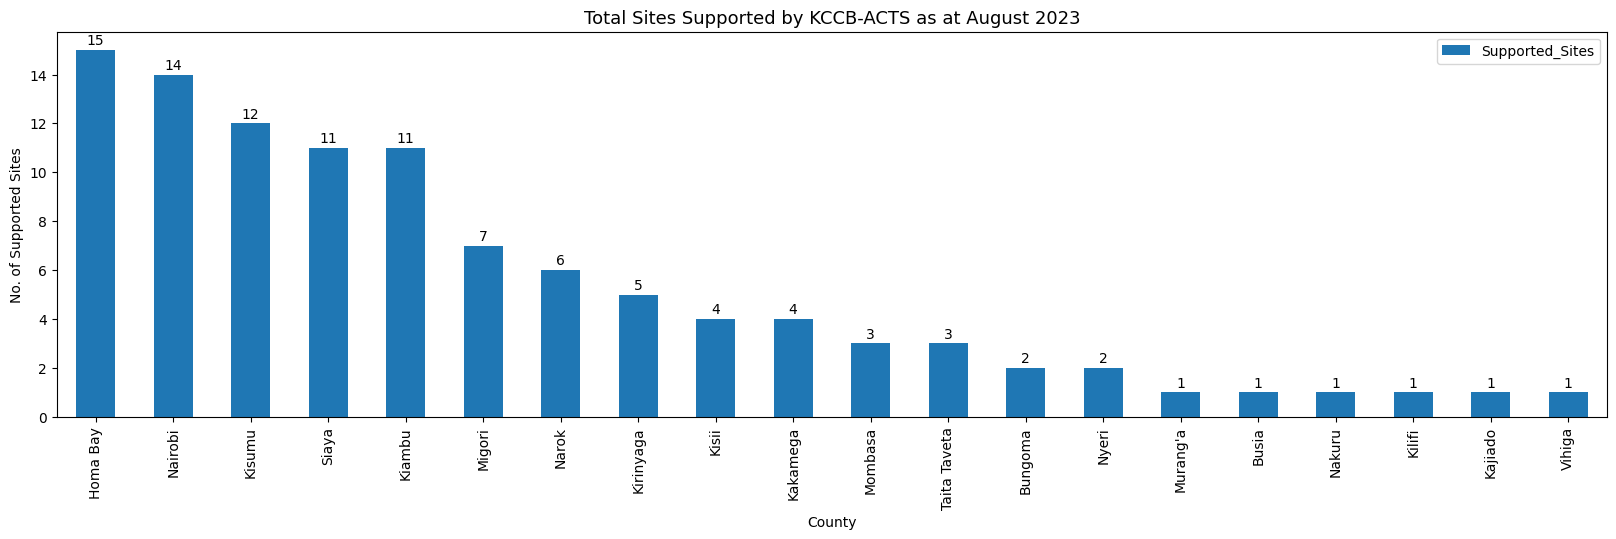

In [13]:
csites = kccb_sites.County.value_counts().reset_index()
csites.columns = ('county','Supported_Sites')
#csites.set_index('county')
#for index,county in csites.county.items():
#    print(str(county));
#basis on our plot; type and size
csites.plot.bar(figsize=(20,5))

#labels of plot axes using the import plt for matplotlib.pyplot
plt.xlabel('County')
plt.ylabel('No. of Supported Sites')
plt.title('Total Sites Supported by KCCB-ACTS as at August 2023', fontsize=13)

#for the xticks to show county names
plt.xticks(csites.index, labels=csites.county)

#plt.axis("off") #removes the borders and whitespace

#annotate values above bars based on index
for county, counts in csites.Supported_Sites.items():
    plt.text(county, counts+0.22, str(counts), fontsize=10, horizontalalignment='center');

### adding more variables to our data by merging with another dataset

In [14]:
#loading dataset with the tx current data for the quarters
txdata = 'raw_data/kccbtxcurrdata.xlsx'

kccbtxdata = pd.read_excel(txdata, usecols={'mfl',
                                            'facility_name', 'txnew2023Q1','txnew2023Q2',
                                            'txnew2023Q3','txnew2023Q4',
                                            '2023Q1','2023Q2','2023Q3','2023Q4'}
                          ).sort_values(by='mfl',
                                        ascending=True)
kccbtxdata.tail(5)

,mfl,facility_name,txnew2023Q1,txnew2023Q2,txnew2023Q3,txnew2023Q4,2023Q1,2023Q2,2023Q3,2023Q4
64,20364,Ringa Dispensary,4,3,8,2,839,835,845,841
103,20692,Vigetse Medical Clinic,10,4,4,2,519,525,528,529
87,20836,St Monica Hospital (Town Clinic),8,9,6,8,1116,1118,1112,1115
78,22771,St Joseph Catholic Dispensary (Maungu),4,3,3,2,281,278,279,284
5,23285,Chaani Catholic Dispensary CBHC,12,8,8,5,649,671,678,681


In [15]:
#to check on our dtypes
kccbtxdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 9 to 5
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   mfl            105 non-null    int64 
 1   facility_name  105 non-null    object
 2   txnew2023Q1    105 non-null    int64 
 3   txnew2023Q2    105 non-null    int64 
 4   txnew2023Q3    105 non-null    int64 
 5   txnew2023Q4    105 non-null    int64 
 6   2023Q1         105 non-null    int64 
 7   2023Q2         105 non-null    int64 
 8   2023Q3         105 non-null    int64 
 9   2023Q4         105 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 9.0+ KB


In [16]:
#show the last 5 records
kccb_sites.tail(5)

,mfl_code,FacilityName,County,SubCounty,Owner,lat,lon,SDP
100,14157,Ulanda Dispensary,Migori,Awendo,Kenya Episcopal Conference-Catholic Secretariat,-1.007030,34.58561,KCCB ACTS
101,17183,Uradi Health Centre,Siaya,Alego Usonga,Kenya Episcopal Conference-Catholic Secretariat,0.121560,34.15762,KCCB ACTS
102,14166,Verna Health Centre,Migori,Rongo,Kenya Episcopal Conference-Catholic Secretariat,-0.794940,34.58272,KCCB ACTS
103,20692,Vigetse Medical Clinic,Vihiga,Vihiga,Nursing Council of Kenya,-0.000603,34.67350,KCCB ACTS
104,14174,Wire Dispensary,Homa Bay,Rachuonyo South,Christian Health Association of Kenya,-0.488500,34.75548,KCCB ACTS


In [17]:
#check for duplicate records
kccbtxdata[kccbtxdata.duplicated()]

,mfl,facility_name,txnew2023Q1,txnew2023Q2,txnew2023Q3,txnew2023Q4,2023Q1,2023Q2,2023Q3,2023Q4


In [18]:
#check for missing values
kccbtxdata.isna().value_counts()

mfl    facility_name  txnew2023Q1  txnew2023Q2  txnew2023Q3  txnew2023Q4  2023Q1  2023Q2  2023Q3  2023Q4
False  False          False        False        False        False        False   False   False   False     105
Name: count, dtype: int64

In [19]:
#renaming the mfl column in the second df
kccbtxdata.rename(columns={'mfl':'mfl_code'}, inplace=True)

#merging the two dataframe where mfl_code is same
#and saving the resulting dataframe as a new dataframe to merge with the next dataset. use to_excel('dir/filename') to save it
tx_coords = (pd.
 merge(kccbtxdata, kccb_sites,
      on=['mfl_code'],
      how='left'))

### adding a dataset with 'region' variable for the sites

In [20]:
#add regions
siteregions = 'raw_data/regiondata.csv'

region_data = pd.read_csv(siteregions, usecols=('Facility',
                                             'MFL Code',
                                             'Region'))

columns=('facility_name',
         'mfl_code',
         'region')

region_data.columns = columns

region_data.sample(1)

,facility_name,mfl_code,region
47,St Paul Dispensary,14123,Siaya


In [21]:
region_data.shape

(57, 3)

In [22]:
#dataset only contains 57 sites, while our kccb_sites dataframe has 105 sites. 
#a quick check on null values in a merge of the two shows this
kccbsites_df = (pd.
 merge(tx_coords, region_data,
      on=['mfl_code'],
      how='left'))

#.fillna(value='Nairobi')
#.isnull().value_counts()

In [23]:
kccbsites_df.sample(3)

,mfl_code,facility_name_x,txnew2023Q1,txnew2023Q2,txnew2023Q3,txnew2023Q4,2023Q1,2023Q2,2023Q3,2023Q4,FacilityName,County,SubCounty,Owner,lat,lon,SDP,facility_name_y,region
38,13739,St Elizabeth Lwak Mission Health Centre,9,10,20,7,1922,1930,1937,1939,St Elizabeth Lwak Mission Health Centre,Siaya,Rarieda,Kenya Episcopal Conference-Catholic Secretariat,-0.13000,34.35000,KCCB ACTS,St Elizabeth Lwak Mission Health Centre,Siaya
10,10825,Nazareth Hospital,20,12,14,9,2113,2082,2060,2054,Nazareth Hospital,Kiambu,Limuru,Kenya Episcopal Conference-Catholic Secretariat,-1.13613,36.72546,KCCB ACTS,NaN,NaN
85,16073,Holy Family Nangina Mission Hospital,12,12,14,13,2651,2647,2459,2492,Holy Family Nangina Mission Hospital,Busia,Samia,Kenya Episcopal Conference-Catholic Secretariat,0.27749,34.10545,KCCB ACTS,Holy Family Nangina Mission Hospital,Western


In [24]:
kccbsites_df.region.unique()

array([nan, 'Siaya', 'HomaBay', 'Kisumu', 'Kisii', 'Western'],
      dtype=object)

In [25]:
#changing region from nan to the appropriate value for the facilities in the newer counties
#kccbsites_df[kccbsites_df.County.str.contains("Nairobi|Narok|Nyeri|Kirinyaga|Murang'a|Kiambu|Nakuru|Kajiado")].assign(region = "Nairobi") #worked but didnt change in place


In [26]:
#rows containing the specific string as a filter
nairobi_region = kccbsites_df.County.str.contains("Nairobi|Narok|Nyeri|Kirinyaga|Murang'a|Kiambu|Nakuru|Kajiado")
mombasa_region = kccbsites_df.County.str.contains("Taita Taveta|Mombasa|Kilifi")

#use loc to take our filters in to fill in the nan values in regions
kccbsites_df.loc[nairobi_region, 'region'] = kccbsites_df.loc[nairobi_region, 'region'].fillna(value='Nairobi')
kccbsites_df.loc[mombasa_region, 'region'] = kccbsites_df.loc[mombasa_region, 'region'].fillna(value='Mombasa')

In [27]:
kccbsites_df.shape

(105, 19)

In [28]:
kccbsites_df.sample(2)

,mfl_code,facility_name_x,txnew2023Q1,txnew2023Q2,txnew2023Q3,txnew2023Q4,2023Q1,2023Q2,2023Q3,2023Q4,FacilityName,County,SubCounty,Owner,lat,lon,SDP,facility_name_y,region
18,11817,St Joseph's Shelter of Hope,9,8,7,5,745,755,742,737,St Joseph's Shelter of Hope,Taita Taveta,Voi,Christian Health Association of Kenya,-3.39082,38.53897,KCCB ACTS,NaN,Mombasa
15,11124,Tumutumu (PCEA) Hospital,8,7,10,3,1904,1886,1846,1846,Tumutumu (PCEA) Hospital,Nyeri,Mathira West,Christian Health Association of Kenya,-0.48549,37.07946,KCCB ACTS,NaN,Nairobi


In [29]:
#check for any missing values
kccbsites_df.region.isna().value_counts()

region
False    105
Name: count, dtype: int64

In [30]:
#our columns and their respective data types
kccbsites_df.dtypes

mfl_code             int64
facility_name_x     object
txnew2023Q1          int64
txnew2023Q2          int64
txnew2023Q3          int64
txnew2023Q4          int64
2023Q1               int64
2023Q2               int64
2023Q3               int64
2023Q4               int64
FacilityName        object
County              object
SubCounty           object
Owner               object
lat                float64
lon                float64
SDP                 object
facility_name_y     object
region              object
dtype: object

In [31]:
#mfl_code to str since no mathematical operations should be done on it
kccbsites_df.mfl_code = kccbsites_df.mfl_code.apply(str)

In [32]:
kccbsites_df = kccbsites_df.drop(['FacilityName','facility_name_y'], axis=1)

In [33]:
#checking to see if our assigning of region is correct
filter = 'Nairobi'

(kccbsites_df
 .query('region==@filter')['County'].unique())

array(['Nyeri', 'Kirinyaga', "Murang'a", 'Kiambu', 'Nairobi', 'Narok',
       'Nakuru', 'Kajiado'], dtype=object)

In [34]:
kccbsites_df.rename(columns={'facility_name_x':'facility_name',
                        'County':'county',
                        'SubCounty':'sub_county',
                        'Owner':'owner'}, inplace=True)

# our final dataframe

In [35]:
#isolate the relevant columns only
#save to excel file
prepd_data = (kccbsites_df[['mfl_code', 'facility_name', 'region',
       'county', 'sub_county', 'owner', 'lat', 'lon', 'txnew2023Q1', 'txnew2023Q2',
       'txnew2023Q3', 'txnew2023Q4', '2023Q1', '2023Q2', '2023Q3', '2023Q4']])


prepd_data.to_excel('processed_data/cleaned_data.xlsx', index=False)

In [36]:
#prepd_data.memory_usage(deep=True).sum()

In [37]:
#some light feature engineering, using np.sum and assign to make a new column to sums the columns of txnew for the quarter
#axis=0 would sum the rows
prepd_data.assign(txnew_total = np.sum(prepd_data[['txnew2023Q1', 'txnew2023Q2','txnew2023Q3', 'txnew2023Q4']], axis=1))

,mfl_code,facility_name,region,county,sub_county,owner,lat,lon,txnew2023Q1,txnew2023Q2,txnew2023Q3,txnew2023Q4,2023Q1,2023Q2,2023Q3,2023Q4,txnew_total
0,10100,Consolata Mission Hospital (Mathari),Nairobi,Nyeri,Nyeri Central,Kenya Episcopal Conference-Catholic Secretariat,-0.413830,36.919700,8,5,5,2,1336,1339,1337,1323,20
1,10221,Gatithi Dispensary,Nairobi,Kirinyaga,Kirinyaga West,Ministry of Health,-0.583200,37.191380,3,1,5,2,148,155,163,163,11
2,10267,Githumu Hospital,Nairobi,Murang'a,Kandara,Christian Health Association of Kenya,-0.826860,36.913380,9,6,3,5,542,545,550,554,23
3,10321,Holy Cross Dispensary,Nairobi,Kiambu,Limuru,Kenya Episcopal Conference-Catholic Secretariat,-1.188910,36.597730,1,2,1,2,311,308,307,307,6
4,10398,Kagio Catholic Dispensary (Mary Immucate Catho...,Nairobi,Kirinyaga,Kirinyaga West,Kenya Episcopal Conference-Catholic Secretariat,-0.631120,37.253870,3,3,2,0,314,316,317,318,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,20364,Ringa Dispensary,HomaBay,Homa Bay,Kabondo Kasipul,Kenya Episcopal Conference-Catholic Secretariat,-0.474640,34.851500,4,3,8,2,839,835,845,841,17
101,20692,Vigetse Medical Clinic,Western,Vihiga,Vihiga,Nursing Council of Kenya,-0.000603,34.673500,10,4,4,2,519,525,528,529,20
102,20836,St Monica Hospital (Town Clinic),Kisumu,Kisumu,Kisumu Central,Kenya MPDB - Institution,-0.091900,34.765980,8,9,6,8,1116,1118,1112,1115,31
103,22771,St Joseph Catholic Dispensary (Maungu),Mombasa,Taita Taveta,Voi,Kenya Episcopal Conference-Catholic Secretariat,-3.568415,38.744856,4,3,3,2,281,278,279,284,12


In [38]:
print(f"Tx New Total for the sites by 2023Q4 is: {np.sum(prepd_data[['txnew2023Q1', 'txnew2023Q2','txnew2023Q3', 'txnew2023Q4']], axis=1).sum()}")

Tx New Total for the sites by 2023Q4 is: 4081


<Axes: >

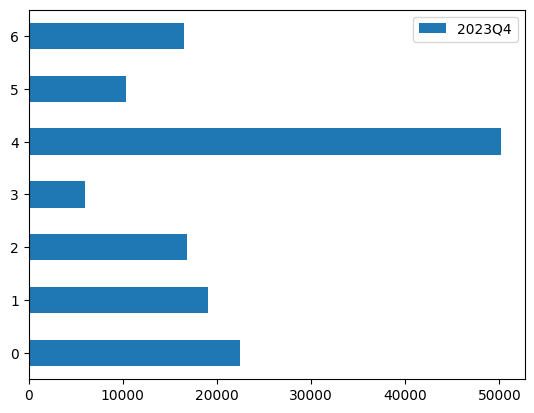

In [39]:
#txq4 total by region
prepd_data.groupby(by=['region'])['2023Q4'].sum().reset_index().plot.barh()

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Nairobi'),
  Text(1, 0, 'Mombasa'),
  Text(2, 0, 'Siaya'),
  Text(3, 0, 'HomaBay'),
  Text(4, 0, 'Kisumu'),
  Text(5, 0, 'Kisii'),
  Text(6, 0, 'Western')])

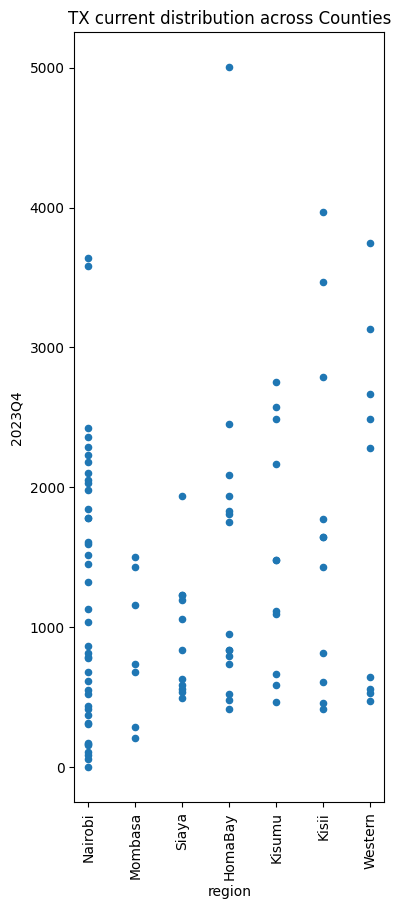

In [40]:
prepd_data[['region','2023Q4']].plot.scatter(x='region', y='2023Q4',figsize=(4,10))
plt.title("TX current distribution across Counties")
plt.xticks(rotation=90)

In [41]:
prepd_data['2023Q4'].nlargest(10)

36    5003
63    3968
84    3747
92    3641
27    3583
60    3467
40    3130
65    2790
52    2750
86    2668
Name: 2023Q4, dtype: int64

#### our streamlit app will mainly be using altair charts

In [42]:
import altair as alt

In [43]:
#the general flow of an altair chart
source = pd.DataFrame({
    "a": ["A", "B", "C"],
    "b": [28, 55, 43]
})

bar = alt.Chart(source).mark_bar().encode(
    y="a:N",
    x=alt.X("b:Q").scale(domain=[0, 60])
)
text = bar.mark_text(
    align="left",
    baseline="middle",
    dx=3
).encode(text="b")

bar + text

alt.LayerChart(...)

In [44]:
#with our data 
data = prepd_data.groupby(by=['region'])['2023Q4'].sum().reset_index()

bar = alt.Chart(data).mark_bar().encode(
    y="region:N",
    x=alt.X("2023Q4:Q"))

text = bar.mark_text(
    align="left",
    baseline="middle",
    dx=3
).encode(text="2023Q4")

bar + text

alt.LayerChart(...)

In [45]:
#with our data 

sitescount = kccb_sites.County.value_counts().reset_index()


bar = alt.Chart(sitescount).mark_bar().encode(
    y=alt.Y("County:N").title("").axis(labels=False),
    x=alt.X("count:Q").title("").axis(labels=False),
    color=alt.Color("County").scale(scheme="category20c"))

bar.configure_legend(
         padding=6,
         orient='bottom')

text = bar.mark_text(
    align="left",
    baseline="middle",
    dx=3
).encode(text="count")

bar + text

alt.LayerChart(...)

In [46]:
quarter_tx = prepd_data.groupby(by=['region'])[['2023Q1','2023Q2','2023Q3','2023Q4']].sum().reset_index()


<Axes: >

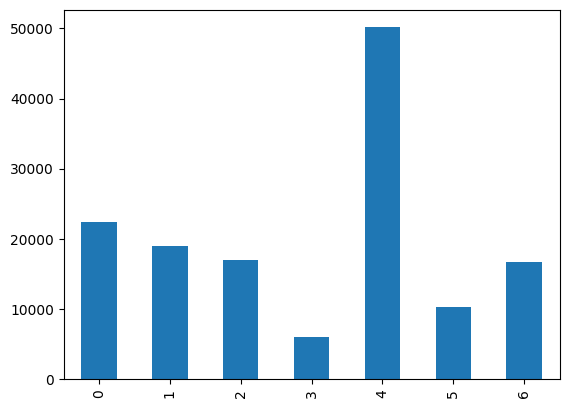

In [47]:
quarter_tx.transpose().loc['2023Q1'].plot.bar()

In [48]:
base = alt.Chart(data).mark_arc(innerRadius=50).encode(
    theta=alt.Theta(field="2023Q4", type="quantitative"),
    color=alt.Color(field="region", type="nominal"),
)

pie = base.mark_arc(outerRadius=150)
text = base.mark_text(radius=170, size=12).encode(
    text="2023Q4:N"
)

base + text

alt.LayerChart(...)

In [49]:
prepd_data['2023Q4'].sum().dtype

dtype('int64')

In [50]:
prepd_data.columns

Index(['mfl_code', 'facility_name', 'region', 'county', 'sub_county', 'owner',
       'lat', 'lon', 'txnew2023Q1', 'txnew2023Q2', 'txnew2023Q3',
       'txnew2023Q4', '2023Q1', '2023Q2', '2023Q3', '2023Q4'],
      dtype='object')

In [51]:

source = (prepd_data.groupby(
         by=['county'])[['txnew2023Q1','txnew2023Q2','txnew2023Q3','txnew2023Q4']]
                  .sum())

alt.Chart(source).mark_rect().encode(
    alt.X("txnew2023Q4:Q").axis(labelAngle=0).title(""),
    alt.Y("county:O").title("Q4"),
    alt.Color("max(txnew2023Q4):Q").title(""),
)

alt.Chart(...)

In [52]:
(prepd_data['2023Q3'] - prepd_data['2023Q2']).sum()

-273

In [53]:
(prepd_data.groupby(
         by=['county'])[['txnew2023Q1','txnew2023Q2','txnew2023Q3','txnew2023Q4']]
                  .sum()
                  .reset_index())


,county,txnew2023Q1,txnew2023Q2,txnew2023Q3,txnew2023Q4
0,Bungoma,17,15,26,13
1,Busia,12,12,14,13
2,Homa Bay,148,129,149,85
3,Kajiado,7,7,6,3
4,Kakamega,66,58,64,58
5,Kiambu,113,110,103,53
6,Kilifi,15,9,12,6
7,Kirinyaga,12,18,12,8
8,Kisii,28,42,44,34
9,Kisumu,126,143,161,98


In [54]:
((prepd_data['txnew2023Q4']) - (prepd_data['txnew2023Q3'])).abs().sum()

641

In [55]:
prepd_data[['txnew2023Q1','txnew2023Q2','txnew2023Q3','txnew2023Q4']].sum()

txnew2023Q1    1098
txnew2023Q2    1142
txnew2023Q3    1214
txnew2023Q4     627
dtype: int64

In [56]:
(prepd_data.groupby(
         by=['region'])[['txnew2023Q1','txnew2023Q2','txnew2023Q3','txnew2023Q4']]
                  .sum()
                  .reset_index().transpose()).style.highlight_max()#.set_index(['txnew2023Q1','txnew2023Q2','txnew2023Q3','txnew2023Q4'])


TypeError: '>=' not supported between instances of 'str' and 'int'

In [57]:
import seaborn as sns

<Axes: ylabel='facility_name'>

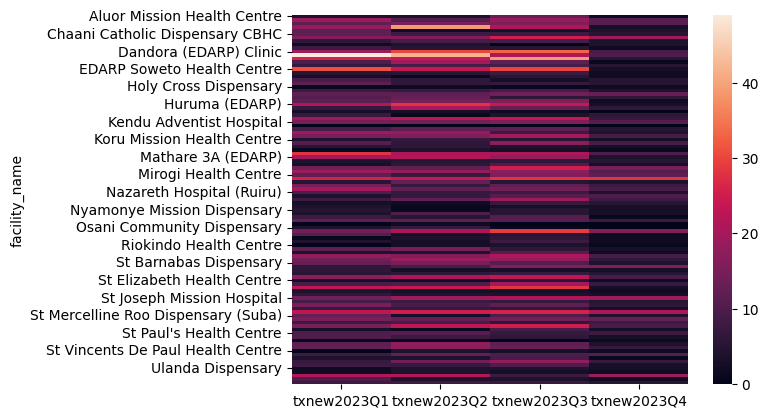

In [58]:
sns.heatmap(prepd_data.groupby(by=['facility_name'])[['txnew2023Q1','txnew2023Q2','txnew2023Q3','txnew2023Q4']].sum())

In [59]:
import streamlit as st

In [60]:
st.altair_chart(prepd_data.groupby(by=['region'])[['txnew2023Q1','txnew2023Q2','txnew2023Q3','txnew2023Q4']].sum().T)

2023-09-27 17:20:05.939 
  command:

    streamlit run c:\Users\FatherMammoth\anaconda3\envs\gisenv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

seems i need a new dataset, showing county tested and new tx

In [61]:
tested_data = 'raw_data/tested_totals.xlsx'
tested_df = pd.read_excel(tested_data)

In [89]:
test_yield = alt.Chart((prepd_data.groupby(by=['county'])[['txnew2023Q4']].sum()).merge(tested_df,
                                                                 on=['county'],
                                                                 how='outer').set_index('county').reset_index()).mark_line().encode(
        x= alt.X("county:N"),
        y= alt.Y("number_tested:Q")).properties(
    height=500,
    width=1000)
        
test_pos = alt.Chart((prepd_data.groupby(by=['county'])[['txnew2023Q4']].sum()).merge(tested_df,
                                                                 on=['county'],
                                                                 how='outer').set_index('county').reset_index()).mark_area().encode(
        x= alt.X("county:N"),
        y= alt.Y("number_positive:Q")).properties(
    height=500,
    width=1000)        
                                                                 
txnewq = alt.Chart((prepd_data.groupby(by=['county'])[['txnew2023Q4']].sum()).merge(tested_df,
                                                                 on=['county'],
                                                                 how='outer').set_index('county').reset_index()).mark_area().encode(
        x= alt.X("county:N"),
        y= alt.Y("txnew2023Q4:Q")).properties(
    height=500,
    width=1000)

test_yield + test_pos

alt.LayerChart(...)

<Axes: xlabel='county', ylabel='index'>

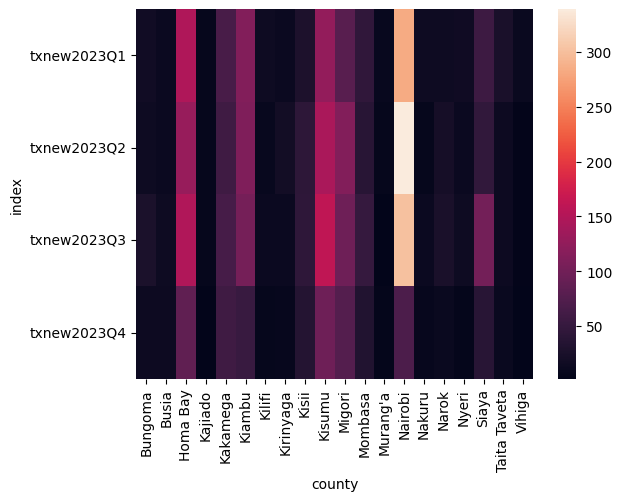

In [107]:
sns.heatmap(((prepd_data[['county','txnew2023Q1','txnew2023Q2',
             'txnew2023Q3','txnew2023Q4']].groupby(
                 by=['county'])[['txnew2023Q1',
                                 'txnew2023Q2','txnew2023Q3','txnew2023Q4']].sum()).transpose().reset_index().set_index('index')), square=False)

In [125]:
test_heat.index.to_list()

['txnew2023Q1', 'txnew2023Q2', 'txnew2023Q3', 'txnew2023Q4']

In [137]:
test_heat = ((prepd_data[['county','txnew2023Q1','txnew2023Q2',
             'txnew2023Q3','txnew2023Q4']].groupby(
                 by=['county'])[['txnew2023Q1',
                                 'txnew2023Q2','txnew2023Q3','txnew2023Q4']].sum()).transpose().reset_index().set_index('index'))
alt.Chart(test_heat).mark_rect().encode(
    x='sum(test_heat.columns.to_list()):Q',
    y='test_heat.index.to_list():O',
    color='sum(test_heat.columns.to_list()):Q'
)

alt.Chart(...)

<Axes: xlabel='county', ylabel='index'>

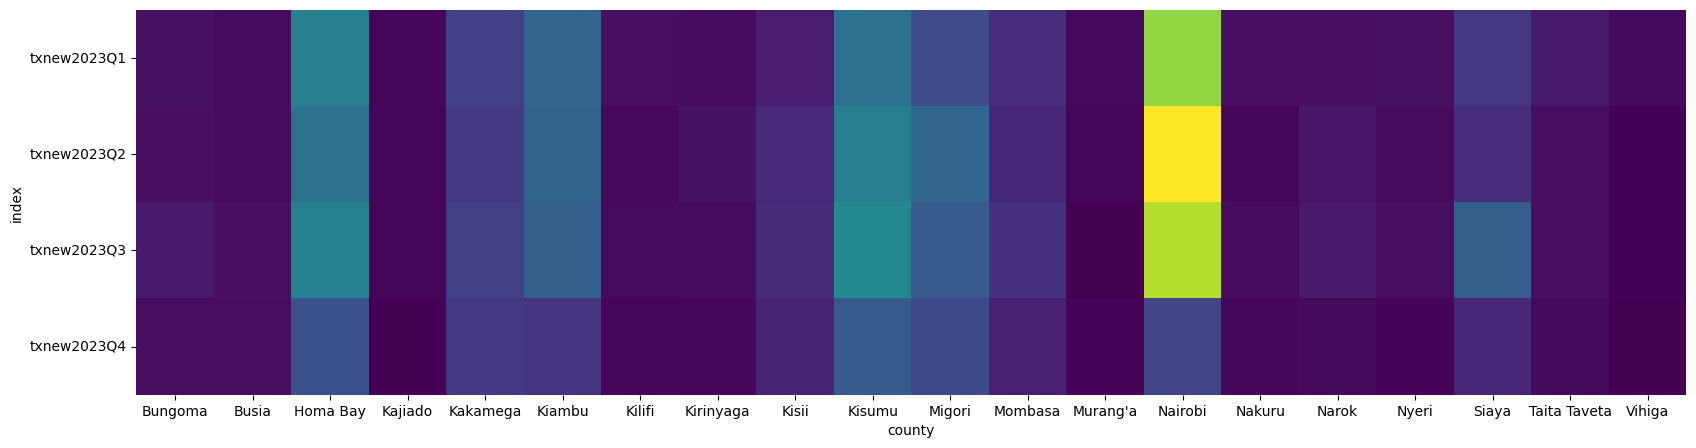

In [138]:
plt.figure(figsize=(20,5))
sns.heatmap(test_heat, cmap='viridis',cbar=False) 